In [1]:
import Model
import tensorflow as tf
import os
import re
import hashlib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

from extractMFCC import computeFeatures, computeFeatures1
from addNoise import addNoise
print(tf.__version__)

2.0.0-beta0


In [2]:
testWAVs = pd.read_csv('Dataset/testing_list.txt', sep=" ", header=None)[0].tolist()
valWAVs  = pd.read_csv('Dataset/validation_list.txt', sep=" ", header=None)[0].tolist()

for idx, item in enumerate(testWAVs):
    testWAVs[idx] = "Dataset/" + testWAVs[idx]

for idx, item in enumerate(valWAVs):
    valWAVs[idx] = "Dataset/" + valWAVs[idx]

In [3]:
DictCategs = {'nine' : 1, 'yes' : 2, 
                         'no' : 3, 'up' : 4, 'down' : 5, 'left' : 6, 'right' : 7, 'on' : 8, 'off' : 9, 'stop' : 10, 'go' : 11,
                         'zero' : 12, 'one' : 13, 'two' : 14, 'three' : 15, 'four' : 16, 'five' : 17, 'six' : 18, 
                         'seven' : 19,  'eight' : 20, 'backward':0, 'bed':0, 'bird':0, 'cat':0, 'dog':0,
                         'follow':0, 'forward':0, 'happy':0, 'house':0, 'learn':0, 'marvin':0, 'sheila':0, 'tree':0,
                         'visual':0, 'wow':0}
nCategs = 21

In [4]:
allWAVs  = []
for root, dirs, files in os.walk('Dataset/'):
    if root != "Dataset/_background_noise_":
        allWAVs += [root+'/'+ f for f in files if f.endswith('.wav')]
trainWAVs = list( set(allWAVs)-set(valWAVs)-set(testWAVs) )

In [5]:
print(len(trainWAVs))
print(len(valWAVs))
print(len(testWAVs))

84843
9981
11005


In [6]:
def _getFileCategory(file, catDict):
    """
    Receives a file with name Dataset/<cat>/<filename> and returns an integer that is catDict[cat]
    """
    categ = os.path.basename(os.path.dirname(file))
    return catDict.get(categ,0)

In [7]:
#get categories
testWAVlabels = [_getFileCategory(f, DictCategs) for f in testWAVs]
valWAVlabels = [_getFileCategory(f, DictCategs) for f in valWAVs]
trainWAVlabels = [_getFileCategory(f, DictCategs) for f in trainWAVs]

In [8]:
print(len(trainWAVlabels))
print(len(valWAVlabels))
print(len(testWAVlabels))

84843
9981
11005


In [12]:
train = np.zeros((len(trainWAVlabels), 99, 39))
for i in range(len(trainWAVs)):
    # print(i)
    # get features and normalize(easy to change to a different normalization):
    feats = computeFeatures(trainWAVs[i])
    mean = np.mean(feats, axis = 0)
    stv = np.std(feats, axis = 0)
    diff = np.subtract(feats, mean)
    feats = np.divide(diff, stv)
    # add to training set the normalized features matrix:
    train[i, :, :] = feats
#prova = computeFeatures(trainWAVs[0])
#print(prova.shape)

/home/jupyter/HDA_Project/extractMFCC.py:25: RuntimeWarning: invalid value encountered in log10
  log_E_s = np.log10(E_s)
/home/jupyter/HDA_Project/extractMFCC.py:39: RuntimeWarning: divide by zero encountered in log10
  log_E_deltas = np.log10(E_deltas)
/home/jupyter/HDA_Project/extractMFCC.py:44: RuntimeWarning: divide by zero encountered in log10
  log_E_deltas_2 = np.log10(E_deltas_2)


KeyboardInterrupt: 

In [9]:
#np.save('train.npy', train)
train = np.load('train.npy')

(84843, 99, 39, 1)
[[-8.67481879e+00 -9.43717319e+00 -7.83291626e+00 ... -1.11337473e+01
  -1.42419900e+01 -1.51777168e+01]
 [ 1.21589337e-02 -2.22224686e+00  5.24716800e+00 ... -3.60750445e+00
  -8.84950047e+00 -7.06162276e+00]
 [ 1.24593071e+00 -1.86096408e+00 -2.02570205e+00 ...  3.31946962e+00
  -1.49632721e+00 -6.12576534e+00]
 ...
 [ 7.39613893e-01  7.28508162e-01  7.60082966e-01 ...  7.34874189e-01
   7.52200233e-01  7.54274676e-01]
 [ 1.69951962e+00  2.39745496e+00  2.44090984e+00 ...  2.13395247e+00
   1.94241013e+00  1.77845653e+00]
 [ 1.69951962e+00  2.39745496e+00  2.44090984e+00 ...  2.13395247e+00
   1.94241013e+00  1.77845653e+00]]


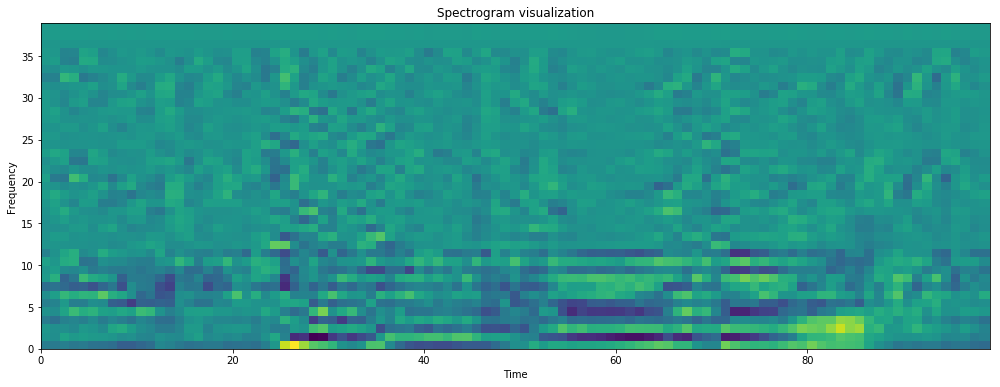

In [20]:
train = train.reshape(train.shape[0], 99, 39, 1)
print(train.shape)

prova = train[78541, :, :, 0]
prova = np.transpose(prova)
print(prova)

plt.figure(figsize=(17,6))
plt.pcolormesh(prova)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [21]:
model = Model.AttentionModel(21, 99, 39, use_GRU = True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 99, 39, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 39, 10)   60          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 39, 10)   40          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 39, 1)    51          batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(x = train, y = trainWAVlabels, batch_size = 32, epochs = 1, use_multiprocessing = True, workers = 8, verbose = 1, shuffle = True)

W0618 06:58:24.737238 140694294677248 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 84843 samples
28288/84843 [=========>....................] - ETA: 36:11 - loss: 2.7990 - accuracy: 0.2678

KeyboardInterrupt: 